# Linear regression

In this lesson we will learn how to perform a simple linear regression by examining the counts, weight, and size measurements of juvenile snowshoe hares observed at the Bonanza Creek Experimental Forest from 1999 to 2012 @kielland_snowshoe_2017. 

<!--TODO: include learning objectives -->

## About the data

Size measurements, sex, and age of snowshoe hares were collected and made available by Dr. Knut Kielland and colleagues at the Bonanza Creek Experimental Forest Long Term Ecological Research (LTER) site located approximately 20 km southwest of Fairbanks, Alaska. The data contains observations of 3380 snowshoe hares obtained by capture-recapture studies conducted yearly from 1999 to 2012 in three sampling sites: Bonanza Riparian, Bonanza Mature and Bonanza Black Spruce. 

Let's start by loading the data and taking a very high-level look at it:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
hares= pd.read_csv(os.path.join('data','knb-lter-bnz','55_Hare_Data_2012.txt'))
hares.head()

,date,time,grid,trap,l_ear,r_ear,sex,age,weight,hindft,notes,b_key,session_id,study
0,11/26/1998,NaN,bonrip,1A,414D096A08,NaN,NaN,NaN,1370.0,160.0,NaN,917.0,51,Population
1,11/26/1998,NaN,bonrip,2C,414D320671,NaN,M,NaN,1430.0,NaN,NaN,936.0,51,Population
2,11/26/1998,NaN,bonrip,2D,414D103E3A,NaN,M,NaN,1430.0,NaN,NaN,921.0,51,Population
3,11/26/1998,NaN,bonrip,2E,414D262D43,NaN,NaN,NaN,1490.0,135.0,NaN,931.0,51,Population
4,11/26/1998,NaN,bonrip,3B,414D2B4B58,NaN,NaN,NaN,1710.0,150.0,NaN,933.0,51,Population


In [3]:
hares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3380 entries, 0 to 3379
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        3380 non-null   object 
 1   time        264 non-null    object 
 2   grid        3380 non-null   object 
 3   trap        3368 non-null   object 
 4   l_ear       3332 non-null   object 
 5   r_ear       3211 non-null   object 
 6   sex         3028 non-null   object 
 7   age         1269 non-null   object 
 8   weight      2845 non-null   float64
 9   hindft      1633 non-null   float64
 10  notes       243 non-null    object 
 11  b_key       3333 non-null   float64
 12  session_id  3380 non-null   int64  
 13  study       3217 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 369.8+ KB


To facilitate our data wrangling we convert the `date` column to a `datetime` type:

In [4]:
hares['date'] = pd.to_datetime(hares['date'])
print(hares.date.dtype)

datetime64[ns]


## Examining hares age data

From the data summary we can see that the `age` column has 1269 non-NA rows. In this example we are interested in working with data from juvenile hares. So we will:

1. Examine the values in the `age` column
2. Filter for observations in which age is 'adult' or 'juvenile'
3. Investigate the age distributions across time.

From the [dataset's metadata](https://portal.edirepository.org/nis/metadataviewer?packageid=knb-lter-bnz.55.22) we know there are three allowedd values in the `age` column: 'a' for 'adult', 'j' for 'juvenile', and 'm' for 'mortality'. Let's see the data in this column:

In [5]:
# Examine unique values and counts in age column
pd.DataFrame(hares['age'].value_counts(dropna=False))

,count
age,
NaN,2111
A,564
J,267
a,183
j,128
1/2/2013,21
1/4/2013,21
3/4/2013,18
1,12


We will make a decision here: since the metadata indicates that 'a' indicates adult and 'j' indicates juvenile, we will only keep observations that have 'a' or 'j' (either capitalized or not) included as part of the value. 

In [6]:
# Update age values to juvenile and adult for observations where 'a' and 'j' are included
hares.loc[hares.age.str.contains('j', case=False, na=False), 'age'] = 'juvenile'
hares.loc[hares.age.str.contains('a', case=False, na=False), 'age'] = 'adult'

# Filter for confirmed observations of juveniel and adult hares
hares_juv_adult = hares[hares.age.isin(['juvenile', 'adult'])].copy()
print(f"Number of confirmed juvenile and adult hares: {len(hares_juv_adult)}")

Number of confirmed juvenile and adult hares: 1155


To understand our data a bit better we want to see the distribution of ages across years. Let's wrangle our data a bit to get there:

In [7]:
# Extract year in which each observation happened
hares_juv_adult['year'] = hares_juv_adult.date.dt.year

# Create hares/year dataframe
hares_per_year = (hares_juv_adult.groupby(['year','age']).size()   # Note: size() counts all elements, including NAs
                                 .reset_index(name='counts')       # Remove multi-index
                                 .pivot(index='year', columns='age', values='counts')   # Pivot into long format
                                 )
hares_per_year

age,adult,juvenile
year,,
1999,150.0,126.0
2000,159.0,67.0
2001,72.0,22.0
2002,3.0,NaN
2003,1.0,18.0
2004,NaN,8.0
2005,95.0,48.0
2006,101.0,15.0
2007,13.0,5.0


If  you are wondering, here `year` is the name of the dataframe's row index and `age` is the name of the column index. 
In this format it is easy to create a bar plot to examine the occurrence of juvenile and adult hares:

<Axes: xlabel='year'>

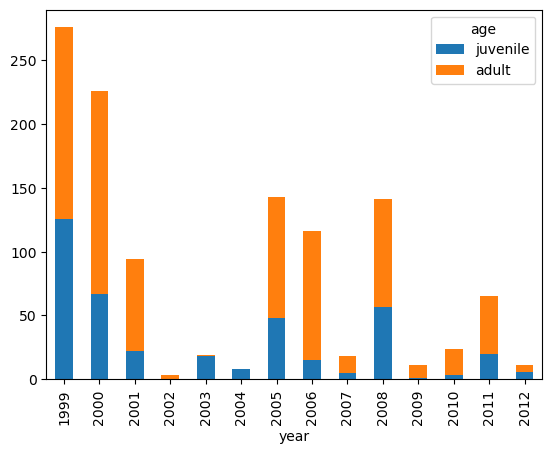

In [8]:
# Quick plot for class demo
hares_per_year[['juvenile', 'adult']].plot(
    kind='bar',
    stacked=True
)

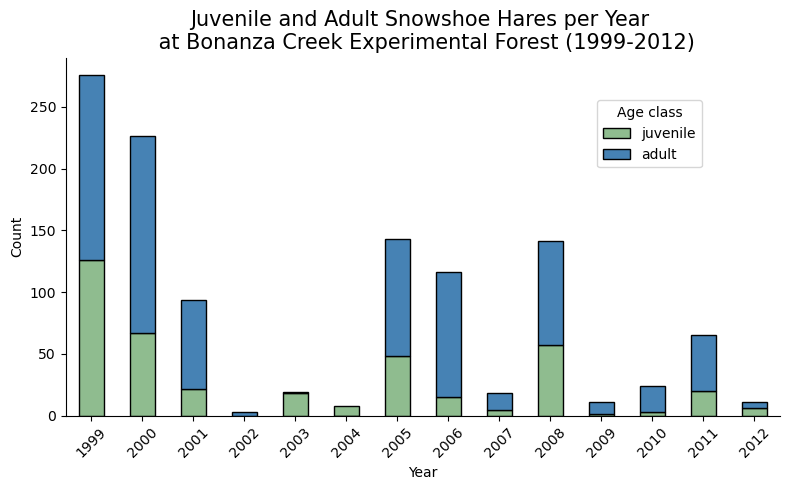

In [9]:
# Create figure + axes
fig, ax = plt.subplots(figsize=(8, 5))

hares_per_year[['juvenile', 'adult']].plot(    # Rearrange columns for stacking order
    kind='bar',
    stacked=True,
    ax=ax,
    edgecolor='black',
    color=["#8FBC8F", "#4682B4"], 
)

# Labels, title, and legend
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.set_title("Juvenile and Adult Snowshoe Hares per Year \n at Bonanza Creek Experimental Forest (1999-2012)",
             {'fontsize':15})
ax.legend(title="Age class",
         loc="upper right",   
         bbox_to_anchor=(0.9, 0.9))

# Axes and axis labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


No observations of juvenile snowshoe hares were made during 2002, while the highest count was registered in 1999 (the first year of the study) with 126 observations. In the previous plot we can see a diminishing trend in the number of juvenile hare trappings. The two exceptions are 2005, 2008 and 2011. 

<!-- In 2005 juvenile hare counts were 6 times higher than in 2004, and in 2008 counts were 8.8 times higher than in 2007. In 2011 the juvenile snowshoe hare count was 9.5 times higher than in 2010. -->

**QUESTION TO STUDENTS**
How could the data collection methods affect the results we see here?

While these are absolute counts, these numbers are also impacted by effort. Moving forward I would suggest to conduct the trappings on the same dates every year and space these times across different seasons. For example the first two weeks of each month every year. I imagine juveniles are mostly present during Spring, but with climate change it is possible Spring weather does not come at the same dates in 2012 as in 1998, so there might be a risk of undercounting if the counts are done during a fixed period of time every year. I would also suggest to maintain the number and location of traps constant over the years.

## Linear regression

For our analysis we want to investigate possible relations between hind foot length and weight for juvenile hares.
We start by taking a look at our target data:

Number of juvenile hares with hind foot and weight measurements: 265


<Axes: xlabel='hindft', ylabel='weight'>

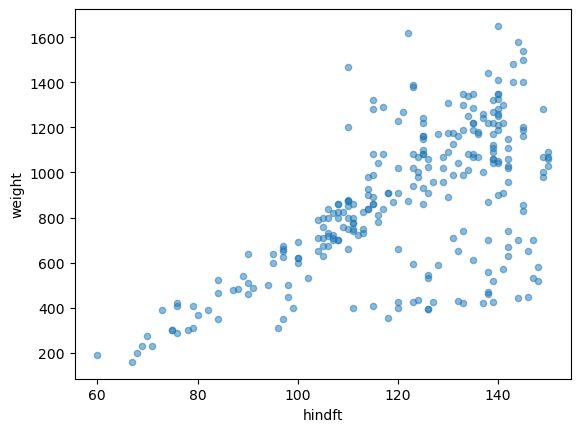

In [10]:
# Subset for juvenile hares with hind foot and weight measurements
juveniles_weight_hindft = hares_juv_adult[(hares_juv_adult['hindft'].notna()) & 
                                          (hares_juv_adult['weight'].notna()) &
                                          (hares_juv_adult['age']=='juvenile')]


print(f"Number of juvenile hares with hind foot and weight measurements: {len(juveniles_weight_hindft)}")
juveniles_weight_hindft.plot.scatter(x='hindft', y='weight', alpha=0.5)

We can see there seems to be some linear trend, though as the hind foot length increases the variability does too. 

Let's investigate whether a linear model is an adequate way to describe this data. To do this we will use the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model from the [`scikit-learn`](https://scikit-learn.org/stable/index.html) library. If you need a refresher about how a linear regression works, [click here](https://openintrostat.github.io/ims/model-slr.html) for a a great resource. 

<!-- TODO: add simple linear model explanation for my own benefit-->


X{array-like, sparse matrix} of shape (n_samples, n_features)
Training data.

yarray-like of shape (n_samples,) or (n_samples, n_targets)
Target values. Will be cast to X’s dtype if necessary.


In [11]:
# Input
X = np.array(juveniles_weight_hindft['hindft']).reshape((-1, 1))   # Reshape to (n_samples, 1)
print(f"Input data shape: {X.shape}")

# Output
y = np.array(juveniles_weight_hindft['weight'])    # Shape is (n_samples,)
print(f"Output data shape: {y.shape}")

# Fit model
model = LinearRegression().fit(X, y)

# Calculate R^2
R_sq = model.score(X, y)
print(f"Coefficient of determination (R^2): {R_sq}")

# Retrieve intercept and slope
intercept = model.intercept_
print(f"x-axis intercept: {intercept}")

slope = model.coef_[0]
print(f"Slope: {slope}")

Input data shape: (265, 1)
Output data shape: (265,)
Coefficient of determination (R^2): 0.3871164783665736
x-axis intercept: -352.77198564640594
Slope: 10.092239638623006


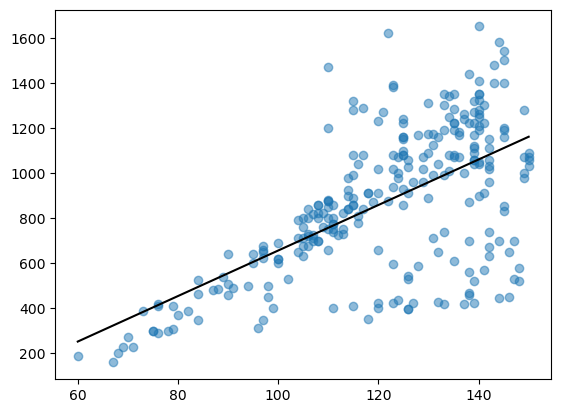

In [12]:
# Quick plot for in-class

fig, ax = plt.subplots()

ax.scatter(x=juveniles_weight_hindft['hindft'], 
           y=juveniles_weight_hindft['weight'], 
           alpha=0.5)

# Define parameters of the regression line
x_start = juveniles_weight_hindft['hindft'].min()
x_end = juveniles_weight_hindft['hindft'].max()

# Plot the line
ax.plot([x_start, x_end], 
        [slope*x_start + intercept, slope*x_end + intercept],
        color="black")
# Show the plot
plt.show()

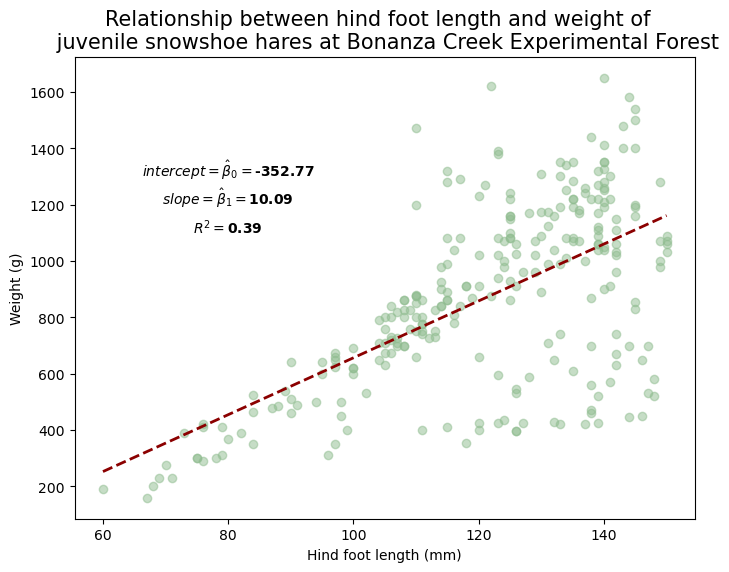

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x=juveniles_weight_hindft['hindft'], 
           y=juveniles_weight_hindft['weight'], 
           alpha=0.5,
           color='#8FBC8F')

# Define parameters of the regression line
x_start = juveniles_weight_hindft['hindft'].min()
x_end = juveniles_weight_hindft['hindft'].max()

# Plot the line
ax.plot([x_start, x_end], 
        [slope*x_start + intercept, slope*x_end + intercept],
        color="darkred", 
        lw=2, 
        linestyle="--")

# Add the parameters
beta0 = r'$intercept = \hat\beta_0 =$' + str(round(intercept,2))
ax.text(80, 1300, beta0, fontsize=10, weight='bold', horizontalalignment='center')

beta1 = r'$slope = \hat\beta_1 =$' + str(round(slope,2))
ax.text(80, 1200, beta1, fontsize=10, weight='bold', horizontalalignment='center')

r_squared = r'$R^2 =$' + str(round(R_sq,2))
ax.text(80, 1100, r_squared, fontsize=10, weight='bold', horizontalalignment='center')        

# Add a title and axis label
ax.set_title('Relationship between hind foot length and weight of  \n juvenile snowshoe hares at Bonanza Creek Experimental Forest',
             {'fontsize':15})
ax.set_xlabel('Hind foot length (mm)')
ax.set_ylabel('Weight (g)')

# Show the plot
plt.show()

In [17]:
juveniles_weight_hindft.sex.unique()

array(['M', 'F', nan, 'F?', 'm', '?', 'f'], dtype=object)

In [23]:
# Predicting
x_new = (np.arange(5)*100).reshape((-1, 1))
x_new

y_new = model.predict(x_new)
y_new

array([-352.77198565,  656.45197822, 1665.67594208, 2674.89990594,
       3684.1238698 ])